In [1]:
!pip install dask==0.15.1
!pip install h5py==2.5.0
!pip install keras==2.0.4

  Using cached h5py-2.5.0.tar.gz
  Running setup.py bdist_wheel for h5py ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - error
  Complete output from command /home/daniel/anaconda3/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-sbt1_f2v/h5py/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/tmp6hv4j1ixpip-wheel- --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.6
  creating build/lib.linux-x86_64-3.6/h5py
  copying h5py/highlevel.py -> build/lib.linux-x86_64-3.6/h5py
  copying h5py/__init__.py -> build/lib.linux-x86_64-3.6/h5py
  copying h5py/ipy_completer.py -> build/lib.linux-x86_64-3.6/h5py
  copying h5py/version.py -> build/lib.linux-x86_64-3.6/h5py
  creating build/lib.linux-x86_64-3.6/h5py/_hl
  copying h5py/_hl/data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import os
import librosa as lr
import shutil
import dask.array as da
from dask.array.image import imread
import h5py
import glob

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from scipy.misc import imresize
import keras
from keras import regularizers
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import Activation, concatenate, add, GRU, LSTM ,Dense, Flatten, InputLayer, Dropout, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Input, Conv1D, Reshape
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
def mp3_to_img(path, height=64, width=64):
    signal, sr = lr.load(path, res_type='kaiser_fast')
    hl = signal.shape[0]//(width) #this will cut away 5% from start and end
    spec = lr.feature.melspectrogram(signal, n_mels=height, hop_length=int(hl))
    img = lr.logamplitude(spec)**2
    start = (img.shape[1] - width) // 2
    return img[:, start:start+width]

In [3]:
train = pd.read_csv('data/train_list.csv').sample(frac=1).reset_index(drop=True)
train.Phonetics.value_counts()

gya     1288
n        957
ka       911
o        895
to       842
shi      821
ko       819
i        815
u        808
hi       782
ku       775
no       769
na       747
mo       730
mi       721
ta       716
ji       709
ni       702
ne       701
ha       701
go       700
chi      697
tsu      694
a        694
ma       694
ki       693
ru       693
wa       693
ge       690
bi       689
        ... 
hyu      644
byu      644
pu       644
pyu      644
ja       644
wi       644
pyo      644
pya      644
pe       644
we       644
ju       644
mya      644
pi       644
po       644
hyo      644
myu      644
dash     644
hya      644
nya      644
wo       644
rya      644
myo      644
chu      644
nyo      644
yo       644
kyu      644
pa       644
bya      644
kya      644
gyo      644
Name: Phonetics, dtype: int64

In [10]:
temp_x = []
temp_y = []

for index, row in train.iterrows():
    img_name = row['Filename']
    img_path = os.path.join('data/jpg/', img_name + '.jpg')
    img = imread(img_path) #mp3_to_img(os.path.join('data/raw/', img_name + '.wav'))
    #img = imresize(img, (60, 12), interp='nearest')
    img = img.reshape(36, 44, 1)
    temp_x.append(img.astype('float32'))
    
train_x = np.stack(temp_x)

train_x = train_x / 255.

In [13]:
import h5py
import dask.array as da

da.from_array(train_x, chunks=1000).to_hdf5('data/data.h5', 'data')

In [14]:
train_x = h5py.File('./data/data.h5', 'r')['data']
train_x = da.from_array(train_x, chunks=1000)

In [15]:
train.Phonetics.value_counts()

gya     1288
n        957
ka       911
o        895
to       842
shi      821
ko       819
i        815
u        808
hi       782
ku       775
no       769
na       747
mo       730
mi       721
ta       716
ji       709
ni       702
ne       701
ha       701
go       700
chi      697
tsu      694
a        694
ma       694
ki       693
ru       693
wa       693
ge       690
bi       689
        ... 
hyu      644
byu      644
pu       644
pyu      644
ja       644
wi       644
pyo      644
pya      644
pe       644
we       644
ju       644
mya      644
pi       644
po       644
hyo      644
myu      644
dash     644
hya      644
nya      644
wo       644
rya      644
myo      644
chu      644
nyo      644
yo       644
kyu      644
pa       644
bya      644
kya      644
gyo      644
Name: Phonetics, dtype: int64

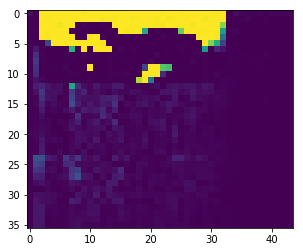

In [16]:
test_img = train_x[0, :, :, 0]
plt.imshow(test_img)
plt.show()

In [17]:
lb = LabelEncoder()
train_y = lb.fit_transform(train.Phonetics)
train_y = keras.utils.np_utils.to_categorical(train_y)
print(list(lb.classes_))

#with open('./data/classes.txt', 'wb') as fp:
#    fp.write("\n".join(list(lb.classes_)).encode('utf-8'))

['a', 'ba', 'be', 'bi', 'bo', 'bu', 'bya', 'byo', 'byu', 'cha', 'chi', 'cho', 'chu', 'da', 'dash', 'de', 'do', 'e', 'fu', 'ga', 'ge', 'gi', 'go', 'gu', 'gya', 'gyo', 'gyu', 'ha', 'he', 'hi', 'ho', 'hya', 'hyo', 'hyu', 'i', 'ja', 'ji', 'jo', 'ju', 'ka', 'ke', 'ki', 'ko', 'ku', 'kya', 'kyo', 'kyu', 'ma', 'me', 'mi', 'mo', 'mu', 'mya', 'myo', 'myu', 'n', 'na', 'ne', 'ni', 'no', 'nu', 'nya', 'nyo', 'nyu', 'o', 'pa', 'pe', 'pi', 'po', 'pu', 'pya', 'pyo', 'pyu', 'ra', 're', 'ri', 'ro', 'ru', 'rya', 'ryo', 'ryu', 'sa', 'se', 'sha', 'shi', 'sho', 'shu', 'so', 'su', 'ta', 'te', 'to', 'tsu', 'u', 'wa', 'we', 'wi', 'wo', 'xtsu', 'ya', 'yo', 'yu', 'za', 'ze', 'zo', 'zu']


In [18]:
print(train_x.shape[0])
print(train_x.shape[1])
print(train_x.shape[2])
print(train_x.shape[3])
#train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2] * train_x.shape[3])

72863
36
44
1


In [19]:
input_num_units = (36, 44, 1)
hidden_num_units = 200
output_num_units = len(train.Phonetics.value_counts())

epochs = 100
batch_size = 128

In [20]:
model = Sequential([
  InputLayer(input_shape=input_num_units),
  Conv2D(64, kernel_size=(10, 44), activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Flatten(),
  Dense(200, activation="relu"),
  Dropout(0.25),
  Dense(200, activation="relu"),
  Dropout(0.25),
  Dense(units=output_num_units, activation='softmax'),
])


In [21]:
model = Sequential([
  InputLayer(input_shape=input_num_units),
  Flatten(),
  Dense(500, activation="elu", kernel_initializer="he_normal"),
  Dense(500, activation="elu", kernel_initializer="he_normal"),
  Dense(500, activation="elu", kernel_initializer="he_normal"),
  Dropout(0.25),
  Dense(500, activation="elu", kernel_initializer="he_normal"),
  Dropout(0.25),
  Dense(units=output_num_units, activation='softmax'),
])

In [27]:
rnn_size = 160

input_tensor = Input(shape=input_num_units)
x = input_tensor
conv_shape = x.get_shape()

model = Sequential([
    InputLayer(input_shape=input_num_units),
    Reshape(target_shape = (int(conv_shape [1]), int(conv_shape[2] * conv_shape[3]))),
    LSTM(500, return_sequences=True),
    LSTM(500, return_sequences=True),
    LSTM(500),
    Dense(500, activation="relu"),
    Dense(output_num_units, activation="softmax")
])

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 36, 44, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1584)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               792500    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
__________

In [23]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

In [ ]:
model.fit(train_x, train_y, batch_size=batch_size,epochs=epochs,verbose=2, validation_split=0.2)

Train on 58290 samples, validate on 14573 samples
Epoch 1/100


/home/daniel/anaconda3/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


82s - loss: 2.8174 - categorical_accuracy: 0.2587 - top_k_categorical_accuracy: 0.6003 - val_loss: 1.9978 - val_categorical_accuracy: 0.4084 - val_top_k_categorical_accuracy: 0.7895
Epoch 2/100
79s - loss: 1.8529 - categorical_accuracy: 0.4466 - top_k_categorical_accuracy: 0.8259 - val_loss: 1.4597 - val_categorical_accuracy: 0.5395 - val_top_k_categorical_accuracy: 0.8895
Epoch 3/100
80s - loss: 1.4094 - categorical_accuracy: 0.5569 - top_k_categorical_accuracy: 0.8993 - val_loss: 1.1363 - val_categorical_accuracy: 0.6278 - val_top_k_categorical_accuracy: 0.9330
Epoch 4/100
79s - loss: 1.1415 - categorical_accuracy: 0.6346 - top_k_categorical_accuracy: 0.9317 - val_loss: 0.9399 - val_categorical_accuracy: 0.6909 - val_top_k_categorical_accuracy: 0.9511
Epoch 5/100
78s - loss: 0.9733 - categorical_accuracy: 0.6844 - top_k_categorical_accuracy: 0.9515 - val_loss: 0.8321 - val_categorical_accuracy: 0.7225 - val_top_k_categorical_accuracy: 0.9611
Epoch 6/100
80s - loss: 0.8604 - categoric

In [ ]:
#3s - loss: 1.5130 - categorical_accuracy: 0.5245 - top_k_categorical_accuracy: 0.8839 - val_loss: 1.6408 - val_categorical_accuracy: 0.4889 - val_top_k_categorical_accuracy: 0.8637
#3s - loss: 1.5106 - categorical_accuracy: 0.5317 - top_k_categorical_accuracy: 0.8774 - val_loss: 1.2672 - val_categorical_accuracy: 0.6153 - val_top_k_categorical_accuracy: 0.9146
#44s - loss: 1.6152 - categorical_accuracy: 0.5103 - top_k_categorical_accuracy: 0.8668 - val_loss: 1.1829 - val_categorical_accuracy: 0.6399 - val_top_k_categorical_accuracy: 0.9308

# conv dense 100 epochs. 58s - loss: 0.2110 - categorical_accuracy: 0.9126 - top_k_categorical_accuracy: 0.9976 - val_loss: 0.6212 - val_categorical_accuracy: 0.8263 - val_top_k_categorical_accuracy: 0.9758

In [ ]:
model.save('MinimalSpellingBee.h5')

In [ ]:
epochs = 100
datagen = ImageDataGenerator(width_shift_range=0.25)

datagen.fit(train_x)
model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=epochs, 
                    verbose=2)

In [ ]:
model.save('MinimalSpellingBee.h5')

In [ ]:
y_prob = model.predict(train_x[0].reshape(1,36,44,1)) 
y_classes = y_prob.argmax(axis=-1)
print(y_prob)
print(y_classes)